<a href="https://colab.research.google.com/github/ElpoderdelComputo/Tutoriales_YouTube/blob/main/U_Net3%2B%2B_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

In [ ]:
pip install tensorflow-addons

In [ ]:
import os
import rasterio
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt # Import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers  # Import the layers module

In [ ]:
# Tamaño de las imágenes (asegúrate de que todas las imágenes tengan el mismo tamaño)
IMG_SIZE = 128
def load_image(image_path):
    with rasterio.open(image_path) as src:
        # Leemos las dos bandas: VV (banda 1) y VH (banda 2)
        img_vv = src.read(1)
        img_vh = src.read(2)

        # Normalizamos las imágenes para tener valores entre 0 y 1
        img_vv = (img_vv - np.min(img_vv)) / (np.max(img_vv) - np.min(img_vv))
        img_vh = (img_vh - np.min(img_vh)) / (np.max(img_vh) - np.min(img_vh))

        # Apilamos las bandas VV y VH para tener una imagen con 2 canales
        img = np.stack((img_vv, img_vh), axis=-1)

        # Redimensionamos la imagen para que tenga el tamaño deseado (256x256)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        return img_resized


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.tif'):
            img = load_image(img_path)
            images.append(img)
    return np.array(images)

In [ ]:
# Función para cargar imágenes TIFF desde una carpeta
def load_tif_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.tif'):  # Solo procesar archivos .tif
            img_path = os.path.join(folder, filename)
            #print(f"Cargando imagen TIFF: {img_path}")
            with rasterio.open(img_path) as src:
                img = src.read([1, 2])  # Lee las primeras tres bandas si es una imagen multibanda
                img = np.moveaxis(img, 0, -1)  # Mover las bandas al último eje para que sea [height, width, channels]
                images.append(img)
    print(f"Imágenes TIFF cargadas desde {folder}: {len(images)}")
    return np.array(images)

# Función para cargar máscaras JPG desde una carpeta
def load_jpg_masks_from_folder(folder):
    masks = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.jpg'):  # Solo procesar archivos .jpg
            mask_path = os.path.join(folder, filename)
            #print(f"Cargando máscara JPG: {mask_path}")
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Cargar en escala de grises
            if mask is not None:
                masks.append(mask)
            else:
                print(f"Error cargando máscara {mask_path}")
    print(f"Máscaras JPG cargadas desde {folder}: {len(masks)}")
    return np.array(masks)

# Cargar imágenes TIFF de entrenamiento
train_images_agua = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/train/agua')
train_images_suelo = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/train/suelo')

# Cargar máscaras JPG de entrenamiento
train_masks_agua = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/train/agua')
train_masks_suelo = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/train/suelo')


# Cargar imágenes TIFF de test
test_images_agua = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/test/agua')
test_images_suelo = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/test/suelo')

# Cargar máscaras JPG de test
test_masks_agua = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/test/agua')
test_masks_suelo = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/test/suelo')


# Cargar imágenes TIFF de validación
valida_images_agua = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/valida/agua')
valida_images_suelo = load_tif_images_from_folder('/content/drive/MyDrive/COMECYT/data3/data128/valida/suelo')

# Cargar máscaras JPG de validación
valida_masks_agua = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/valida/agua')
valida_masks_suelo = load_jpg_masks_from_folder('/content/drive/MyDrive/COMECYT/data3/mascaras/valida/suelo')

# Imprimir el número de imágenes y máscaras cargadas para verificación
print(f"Train Agua: {len(train_images_agua)}, Train Suelo: {len(train_images_suelo)}")
print(f"Test Agua: {len(test_images_agua)}, Test Suelo: {len(test_images_suelo)}")
print(f"Validación Agua: {len(valida_images_agua)}, Validación Suelo: {len(valida_images_suelo)}")

print(f"Máscaras Train Agua: {len(train_masks_agua)}, Máscaras Train Suelo: {len(train_masks_suelo)}")
print(f"Máscaras Test Agua: {len(test_masks_agua)}, Máscaras Test Suelo: {len(test_masks_suelo)}")
print(f"Máscaras Validación Agua: {len(valida_masks_agua)}, Máscaras Validación Suelo: {len(valida_masks_suelo)}")


Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/train/agua: 398
Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/train/suelo: 570
Máscaras JPG cargadas desde /content/drive/MyDrive/COMECYT/data3/mascaras/train/agua: 398
Máscaras JPG cargadas desde /content/drive/MyDrive/COMECYT/data3/mascaras/train/suelo: 570
Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/test/agua: 93
Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/test/suelo: 101
Máscaras JPG cargadas desde /content/drive/MyDrive/COMECYT/data3/mascaras/test/agua: 93
Máscaras JPG cargadas desde /content/drive/MyDrive/COMECYT/data3/mascaras/test/suelo: 101
Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/valida/agua: 92
Imágenes TIFF cargadas desde /content/drive/MyDrive/COMECYT/data3/data128/valida/suelo: 99
Máscaras JPG cargadas desde /content/drive/MyDrive/COMECYT/data3/mascaras/valida/agua: 92
Máscaras JP

In [ ]:
# Epsilon value to avoid zero logarithm
epsilon = 1e-10

# Function to convert images to decibels
def convert_to_decibels(images):
    images_db = []
    for img in images:
        img_db = 10 * np.log10(img + epsilon)  # Convertir cada imagen a dB
        images_db.append(img_db)
    return np.array(images_db)

# Convertir imágenes de entrenamiento, test y validación a decibelios
train_images_agua_db = convert_to_decibels(train_images_agua)
train_images_suelo_db = convert_to_decibels(train_images_suelo)

test_images_agua_db = convert_to_decibels(test_images_agua)
test_images_suelo_db = convert_to_decibels(test_images_suelo)

valida_images_agua_db = convert_to_decibels(valida_images_agua)
valida_images_suelo_db = convert_to_decibels(valida_images_suelo)

# Asegurarse de que las máscaras están en el formato correcto (0 y 1)
train_masks_agua = (train_masks_agua > 0).astype(np.uint8)
train_masks_suelo = (train_masks_suelo > 0).astype(np.uint8)

test_masks_agua = (test_masks_agua > 0).astype(np.uint8)
test_masks_suelo = (test_masks_suelo > 0).astype(np.uint8)

valida_masks_agua = (valida_masks_agua > 0).astype(np.uint8)
valida_masks_suelo = (valida_masks_suelo > 0).astype(np.uint8)

# Verificar dimensiones de las imágenes en decibelios
print(f"Train Agua en dB: {train_images_agua_db.shape}, Train Suelo en dB: {train_images_suelo_db.shape}")
print(f"Test Agua en dB: {test_images_agua_db.shape}, Test Suelo en dB: {test_images_suelo_db.shape}")
print(f"Validación Agua en dB: {valida_images_agua_db.shape}, Validación Suelo en dB: {valida_images_suelo_db.shape}")


Train Agua en dB: (398, 128, 128, 2), Train Suelo en dB: (570, 128, 128, 2)
Test Agua en dB: (93, 128, 128, 2), Test Suelo en dB: (101, 128, 128, 2)
Validación Agua en dB: (92, 128, 128, 2), Validación Suelo en dB: (99, 128, 128, 2)


In [ ]:
'''# Normalización de las imágenes en decibelios (opcional)
def normalize_images(images_db):
    images_db_norm = []
    for img_db in images_db:
        # Escalar las imágenes en dB al rango [0, 1]
        img_db_norm = (img_db - np.min(img_db)) / (np.max(img_db) - np.min(img_db))
        images_db_norm.append(img_db_norm)
    return np.array(images_db_norm)

# Aplicar normalización a las imágenes en dB
train_images_agua_db_norm = normalize_images(train_images_agua_db)
train_images_suelo_db_norm = normalize_images(train_images_suelo_db)

test_images_agua_db_norm = normalize_images(test_images_agua_db)
test_images_suelo_db_norm = normalize_images(test_images_suelo_db)

valida_images_agua_db_norm = normalize_images(valida_images_agua_db)
valida_images_suelo_db_norm = normalize_images(valida_images_suelo_db)'''


In [ ]:
# Concatenar las imágenes y máscaras de agua y suelo: solo se usa decibelios
train_images = np.concatenate([train_images_agua_db, train_images_suelo_db], axis=0)
train_masks = np.concatenate([train_masks_agua, train_masks_suelo], axis=0)

test_images = np.concatenate([test_images_agua_db, test_images_suelo_db], axis=0)
test_masks = np.concatenate([test_masks_agua, test_masks_suelo], axis=0)

valida_images = np.concatenate([valida_images_agua_db, valida_images_suelo_db], axis=0)
valida_masks = np.concatenate([valida_masks_agua, valida_masks_suelo], axis=0)


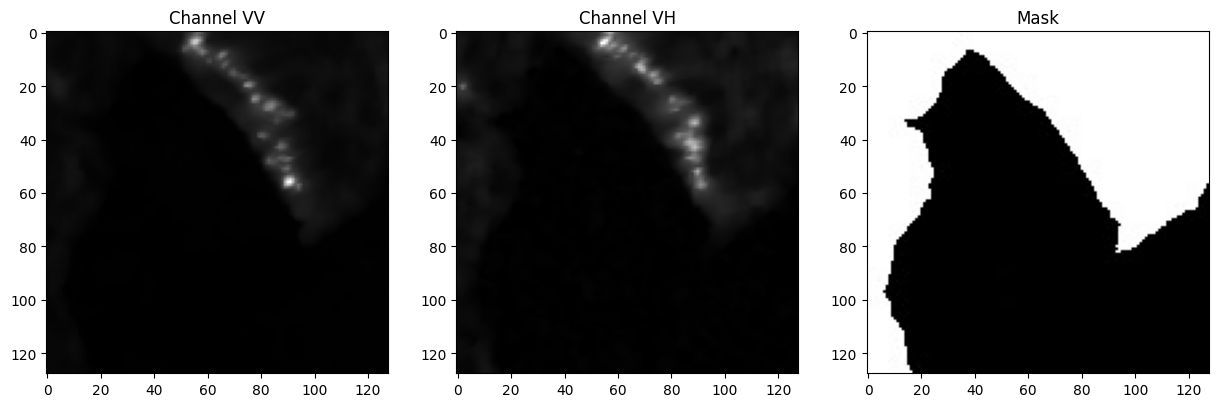

In [ ]:

IMG_SIZE = 128  # Ajusta el tamaño de las imágenes si lo consideras necesario

# Función para cargar una imagen de radar (VV y VH) y su máscara correspondiente
def load_image_and_mask(image_path, mask_path):
    # Cargar imagen TIFF con rasterio (dos bandas VV y VH)
    with rasterio.open(image_path) as src:
        img_vv = src.read(1)  # Leer banda VV
        img_vh = src.read(2)  # Leer banda VH

        # Normalizar las bandas (opcional)
        img_vv = (img_vv - np.min(img_vv)) / (np.max(img_vv) - np.min(img_vv) + 1e-10)
        img_vh = (img_vh - np.min(img_vh)) / (np.max(img_vh) - np.min(img_vh) + 1e-10)

        # Apilar las bandas VV y VH en un array de 2 canales
        img = np.stack((img_vv, img_vh), axis=-1)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Redimensionar la imagen

    # Cargar la máscara desde un archivo .jpg
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Cargar en escala de grises
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))  # Redimensionar la máscara

    return img_resized, mask_resized

# Función para mostrar una imagen y su máscara
def show_image_and_mask(image, mask):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Mostrar el canal VV
    ax[0].imshow(image[..., 0], cmap='gray')  # Mostrar solo el canal VV
    ax[0].set_title("Channel VV")

    # Mostrar el canal VH
    ax[1].imshow(image[..., 1], cmap='gray')  # Mostrar solo el canal VH
    ax[1].set_title("Channel VH")

    # Mostrar la máscara en escala de grises
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title("Mask")

    plt.show()

# Ruta a la imagen y máscara de ejemplo
image_path = '/content/drive/MyDrive/COMECYT/data3/data128/train/agua/A1_1.tif'  # Cambia esto por la ruta de tu imagen
mask_path = '/content/drive/MyDrive/COMECYT/data3/mascaras/train/agua/A1_1.jpg'  # Cambia esto por la ruta de tu máscara

# Cargar y mostrar la imagen y su máscara
image, mask = load_image_and_mask(image_path, mask_path)
show_image_and_mask(image, mask)


In [ ]:
# Argumentos de data augmentation solo para imágenes
data_gen_args_img = dict(rotation_range=20,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode='nearest')

# Argumentos de data augmentation solo para máscaras
data_gen_args_mask = dict(rotation_range=20,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args_img)
mask_datagen = ImageDataGenerator(**data_gen_args_mask)


# Crear un generador personalizado para aplicar data augmentation tanto a imágenes como a máscaras
def train_generator(image_datagen, mask_datagen, images, masks, batch_size):
    # Expandir dimensiones si es necesario para tener 4 dimensiones
    if images.ndim == 3:  # Si las imágenes son (batch_size, height, width)
        images = np.expand_dims(images, axis=-1)  # Añadir canal (batch_size, height, width, 1)

    if masks.ndim == 3:  # Si las máscaras son (batch_size, height, width)
        masks = np.expand_dims(masks, axis=-1)  # Añadir canal (batch_size, height, width, 1)

    # Crear generadores de imágenes y máscaras
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)

    # Combina generadores de imágenes y máscaras
    while True:
        # Usar next() de manera correcta en TensorFlow/Keras
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)

        # Asegúrate de que las imágenes y las máscaras sean de las mismas dimensiones
        yield (image_batch, mask_batch)

# Establecer el batch size
batch_size = 4

# Crear el generador de entrenamiento
train_gen = train_generator(image_datagen, mask_datagen, train_images, train_masks, batch_size)



/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (968, 128, 128, 2) (2 channels).
  warnings.warn(


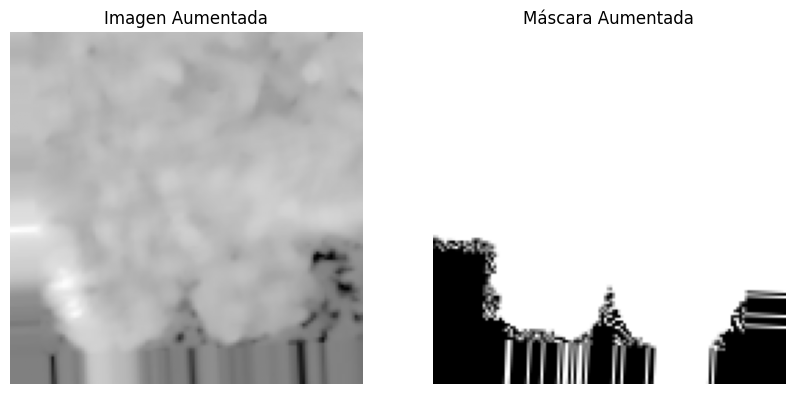

In [ ]:
# Tomar un lote del generador
images, masks = next(train_gen)

# Visualizar la primera imagen y su máscara del lote
plt.figure(figsize=(10, 5))

# Mostrar la imagen aumentada (solo el canal VV)
plt.subplot(1, 2, 1)
plt.imshow(images[0, :, :, 0], cmap='gray')  # Selecciona la banda 0
plt.title("Imagen Aumentada")
plt.axis('off')

# Mostrar la máscara aumentada
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Máscara Aumentada")
plt.axis('off')

plt.show()

In [ ]:
# TRAIN MODEL UNET3+

# Definir Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    # Casting y_true_f to float32 to match y_pred_f
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Combinar Binary Crossentropy y Dice Loss
def combined_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def conv_block(x, filters):
    """Bloque de convolución."""
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(x, filters):
    """Bloque del codificador."""
    conv = conv_block(x, filters)
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    """Bloque del decodificador."""
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def UNet3Plus(input_shape):
    """Definición de UNet 3+."""
    inputs = layers.Input(input_shape)

    # Encoder
    conv1, pool1 = encoder_block(inputs, 64)
    conv2, pool2 = encoder_block(pool1, 128)
    conv3, pool3 = encoder_block(pool2, 256)
    conv4, pool4 = encoder_block(pool3, 512)

    # Bottleneck
    bottleneck = conv_block(pool4, 1024)

    # Decoder
    dec4 = decoder_block(bottleneck, conv4, 512)
    dec3 = decoder_block(dec4, conv3, 256)
    dec2 = decoder_block(dec3, conv2, 128)
    dec1 = decoder_block(dec2, conv1, 64)

    # Salida
    outputs = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(dec1)

    return Model(inputs, outputs)

# Crear modelo
input_shape = (128, 128, 2)  # 128x128 píxeles, 2 bandas
model = UNet3Plus(input_shape)

#modelu3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=combined_loss,
                  metrics=['accuracy', dice_coef])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 2)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,216 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128, 128, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 64, 64, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 128)    │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 256)    │          1,024 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,054,721 (118.46 MB)

 Trainable params: 31,042,945 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# entrenamiento del modelo
history3 = model.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    batch_size=8,
    epochs=10
)

# Guardar el modelo entrenado
model.save('unet_3_plus.h5')

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 76s 315ms/step - accuracy: 0.9039 - dice_coef: 0.8788 - loss: 0.3620 - val_accuracy: 0.8055 - val_dice_coef: 0.7121 - val_loss: 0.7530
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9620 - dice_coef: 0.9542 - loss: 0.1547 - val_accuracy: 0.9671 - val_dice_coef: 0.9377 - val_loss: 0.1483
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9652 - dice_coef: 0.9572 - loss: 0.1378 - val_accuracy: 0.9702 - val_dice_coef: 0.9439 - val_loss: 0.1308
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.9697 - dice_coef: 0.9628 - loss: 0.1164 - val_accuracy: 0.9698 - val_dice_coef: 0.9544 - val_loss: 0.1154
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9670 - dice_coef: 0.9614 - loss: 0.1235 - val_accuracy: 0.9722 - val_dice_coef: 0.9562 - val_loss: 0.1058
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.9695 - dice_coef: 0.9650 - loss: 0.1093 - val_accuracy: 

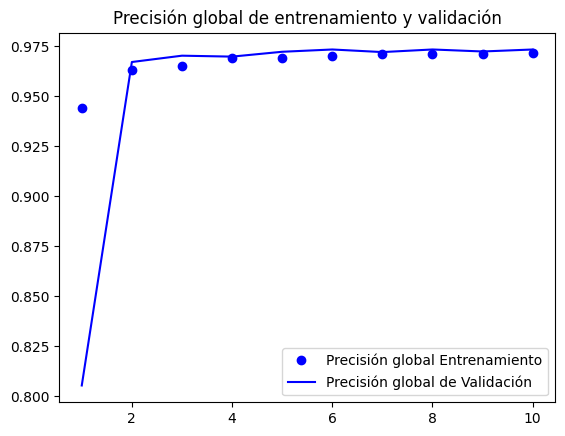

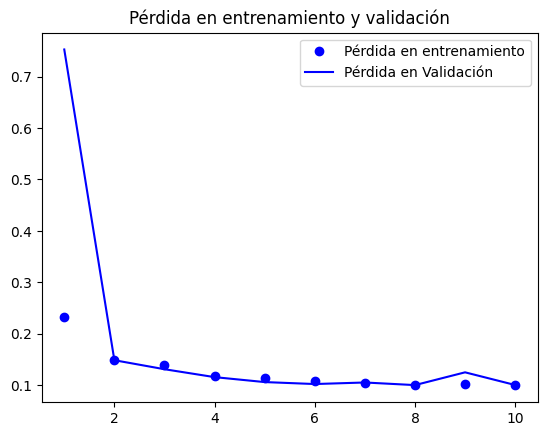

In [ ]:
## Graficando perdidas UNET3+

accuracy = history3.history["accuracy"]
val_accuracy = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Precisión global Entrenamiento")
plt.plot(epochs, val_accuracy, "b", label="Precisión global de Validación")
plt.title("Precisión global de entrenamiento y validación")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Pérdida en entrenamiento")
plt.plot(epochs, val_loss, "b", label="Pérdida en Validación")
plt.title("Pérdida en entrenamiento y validación")
plt.legend()
plt.show()

In [ ]:
# Evaluar el modelo unet3+
loss, accuracy, iou_score = model.evaluate(valida_images, valida_masks)
print(f"Accuracy en test: {accuracy * 100:.2f}%")
print(f"IoU en test: {iou_score:.2f}")

from keras import backend as K

def iou(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

model.compile(optimizer='adam', loss='combined_loss', metrics=['accuracy', iou])

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9727 - dice_coef: 0.9493 - loss: 0.1129
Accuracy en test: 97.29%
IoU en test: 0.96


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


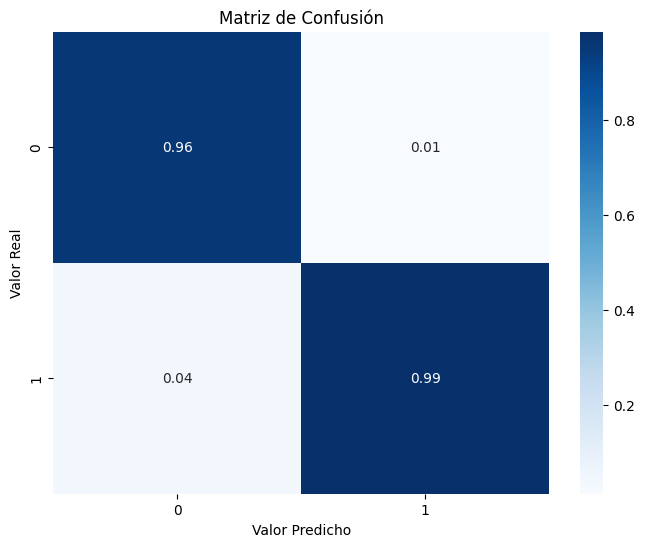

Verdaderos Negativos (TN): 0.9581092150361478
Falsos Positivos (FP): 0.014215221799572467
Falsos Negativos (FN): 0.041890784963852186
Verdaderos Positivos (TP): 0.9857847782004275


In [ ]:
# Importar las bibliotecas necesarias
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones del modelo
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Binarizar las predicciones
y_true = test_masks

# Reformatear las matrices si es necesario
y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true_flat, y_pred_flat, normalize='pred')

# Crear una visualización más atractiva usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Calcular métricas adicionales
TN, FP, FN, TP = cm.ravel()
print(f'Verdaderos Negativos (TN): {TN}')
print(f'Falsos Positivos (FP): {FP}')
print(f'Falsos Negativos (FN): {FN}')
print(f'Verdaderos Positivos (TP): {TP}')

In [ ]:
pip install scipy numpy opencv-python

In [ ]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import cv2

def calculate_hausdorff_distance(y_true, y_pred):
    """
    Calcula la distancia de Hausdorff entre dos máscaras binarias.
    """
    # Asegurar que las máscaras tengan la misma forma
    if y_true.shape != y_pred.shape:
        # Ajustar la forma de pred_mask si es necesario
        y_pred = y_pred.squeeze()  # Eliminar dimensiones extras si las hay

    # Asegurar que las máscaras sean binarias
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    # Obtener coordenadas de los píxeles positivos
    y_true_coords = np.array(np.where(y_true)).T
    y_pred_coords = np.array(np.where(y_pred)).T

    # Verificar si hay puntos en ambas máscaras
    if len(y_true_coords) == 0 or len(y_pred_coords) == 0:
        return np.nan

    try:
        # Calcular la distancia de Hausdorff
        hausdorff_dist = max(directed_hausdorff(y_true_coords, y_pred_coords)[0],
                           directed_hausdorff(y_pred_coords, y_true_coords)[0])
        return hausdorff_dist
    except ValueError as e:
        print(f"Error en el cálculo: {e}")
        print(f"Forma de y_true_coords: {y_true_coords.shape}")
        print(f"Forma de y_pred_coords: {y_pred_coords.shape}")
        return np.nan

# Calcular la distancia de Hausdorff para todo el conjunto de validación
distances = []
for i in range(len(valida_masks)):
    # Obtener la imagen y hacer la predicción
    image = valida_images[i:i+1]  # Añadir dimensión de batch
    pred_mask = model.predict(image)[0]

    # Binarizar la máscara predicha
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Imprimir formas para debug
    print(f"Forma de valida_masks[i]: {valida_masks[i].shape}")
    print(f"Forma de pred_mask: {pred_mask.shape}")

    # Calcular la distancia de Hausdorff
    hd = calculate_hausdorff_distance(valida_masks[i], pred_mask)
    distances.append(hd)

# Calcular y mostrar estadísticas
distances = np.array(distances)
valid_distances = distances[~np.isnan(distances)]  # Eliminar valores NaN si los hay

if len(valid_distances) > 0:
    print(f"\nEstadísticas de la Distancia de Hausdorff:")
    print(f"Promedio: {np.mean(valid_distances):.4f}")
    print(f"Desviación estándar: {np.std(valid_distances):.4f}")
    print(f"Mínima: {np.min(valid_distances):.4f}")
    print(f"Máxima: {np.max(valid_distances):.4f}")
else:
    print("No se pudieron calcular distancias válidas")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Forma de valida_masks[i]: (128, 128)
Forma de pred_mask: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━

In [ ]:
mean_hd = np.mean(distances)
std_hd = np.std(distances)
print(f"Distancia de Hausdorff Media: {mean_hd:.2f}")
print(f"Desviación Estándar de la Distancia de Hausdorff: {std_hd:.2f}")


Distancia de Hausdorff Media: 14.91
Desviación Estándar de la Distancia de Hausdorff: 15.87


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


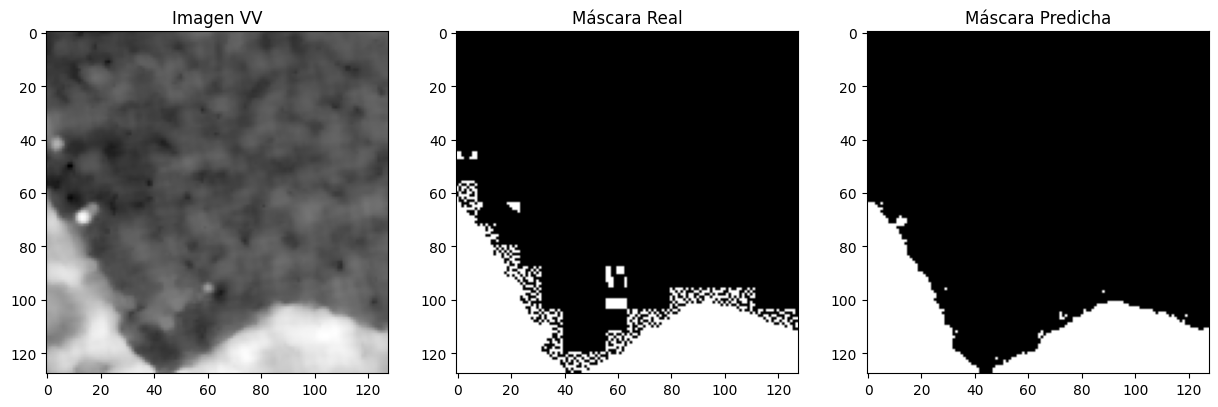

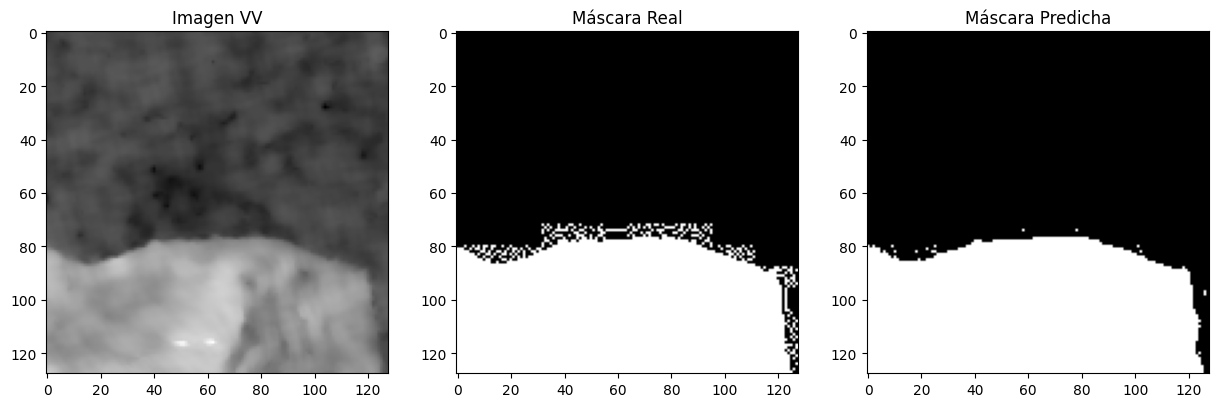

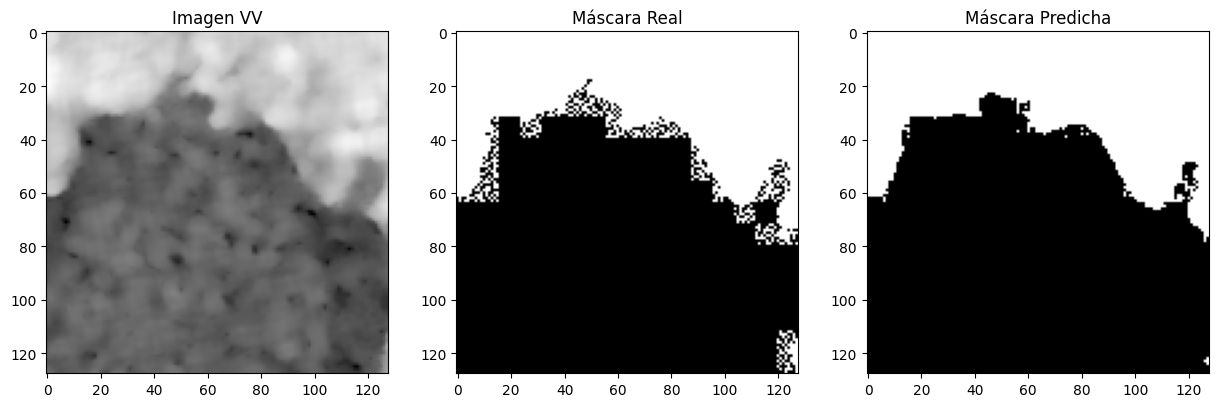

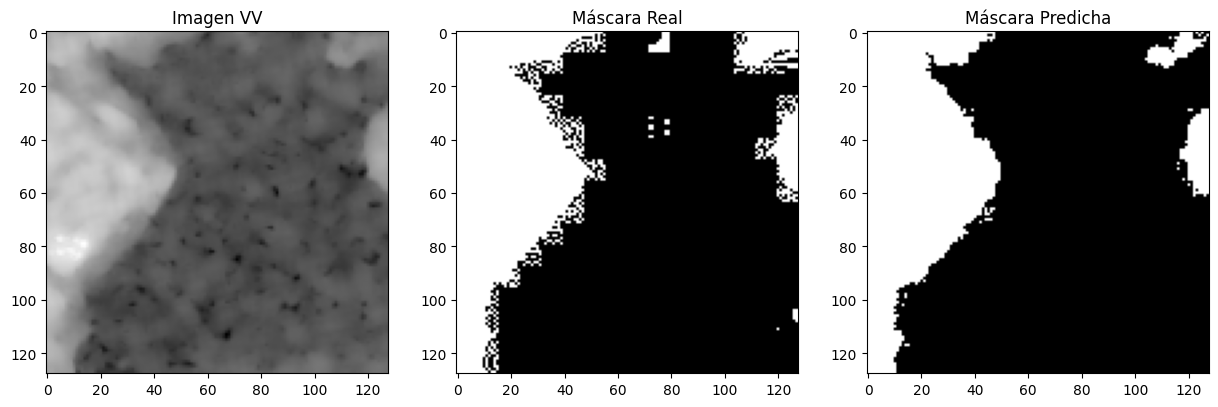

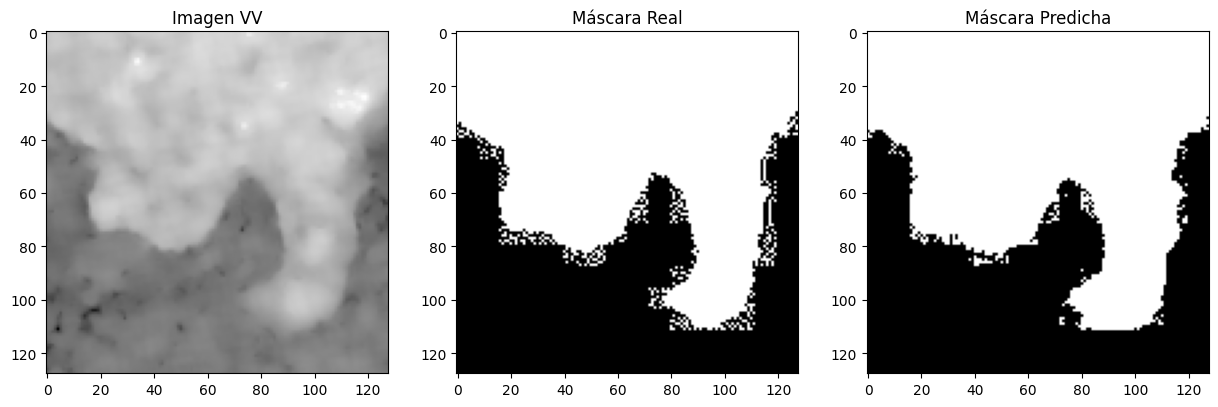

In [ ]:
# Visualizar algunas predicciones del MODELO 1

def plot_sample(image, mask, pred_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Mostrar el canal VV o VH, asegúrate de ajustar el título
    ax1.imshow(image[..., 0], cmap='gray')  # Canal VV
    ax1.set_title('Imagen VV')  # Cambia a 'Imagen VH' si decides mostrar el canal VH

    # Mostrar la máscara real
    ax2.imshow(np.squeeze(mask), cmap='gray')  # Eliminar cualquier dimensión extra de la máscara
    ax2.set_title('Máscara Real')

    # Convertir la predicción a binaria si es necesario
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)  # Convertir la predicción a binaria
    ax3.imshow(np.squeeze(pred_mask_binary), cmap='gray')  # Mostrar la máscara predicha
    ax3.set_title('Máscara Predicha')

    plt.show()

# Predecir algunas imágenes
pred_masks = model.predict(valida_images[0:5])

for i in range(5):
    plot_sample(valida_images[i], valida_masks[i], pred_masks[i])